In [1]:
import os
import glob
import warnings
import traceback

from multiprocessing import Pool

import netCDF4
import pyart
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

warnings.simplefilter('ignore')

/short/kl02/vhl548/miniconda3/envs/radar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cluttermask = "/home/548/vhl548/projects/CALIBRATION_codes/RCA/saved_mask/CLUTTER_map_CPOL_20061210.nc"

In [66]:
flist = glob.glob("/g/data2/rr5/vhl548/CPOL_level_1a/2007/**/*.nc")

In [4]:
def read_elev(infile, dbz_name='DBZ'):
    with netCDF4.Dataset(infile, "r") as ncid:
        # Extract datetime
        dtime = netCDF4.num2date(ncid['time'][0], ncid['time'].units)
        sweep = ncid["sweep_start_ray_index"][:]
        myslice = slice(sweep[0], sweep[1] - 1)
        elev = ncid["elevation"][myslice]

    return dtime, elev, elev.std()

In [5]:
# with Pool(16) as pool:
#     rslt = list(tqdm.tqdm(pool.imap(read_elev, flist), total=len(flist)))

In [6]:
# date_time, elev_mean, elev_std = zip(*rslt)
# elev_mean = np.array(elev_mean)
# elev_mean[elev_mean>1] = np.NaN

In [7]:
# pl.plot(date_time, elev_mean, '+')
# pl.ylim(0.3, 0.6)
# pl.ylabel('Elevation angle sweep 1')
# pl.show()

In [8]:
# pl.hist(elev_mean, range=(0.3, .6), bins=6)
# pl.xlabel('Elevation angle sweep 1')
# pl.show()

In [9]:
def extract_clutter(r, azi, r_mask, th_mask, reflec):
    """
    Extract reflectivity data that has the same (r, azi) as the clutter mask.

    Parameters:
    ===========
        radar: struct
            Py-ART radar structure.
        r_mask: numpy.array(float)
            Clutter range.
        th_mask: numpy.array(float)
            Clutter azimuth.
        dbz_name: str
            Reflectivity field name.

    Returns:
    ========
        clut: numpy.array(float)
            Extracted clutter reflectivity.
    """
    reflec[reflec < 10] = np.NaN
    dr = r[1] - r[0]
    # Angle variation tolerance
    dazi = 0.5

    clut = np.zeros(len(r_mask)) + np.NaN
    for cnt, (the_r, the_azi) in enumerate(zip(r_mask, th_mask)):
        pos_r = np.where((the_r >= r - dr) & (the_r < r + dr))[0]
        pos_azi = np.where((azi >= the_azi - dazi) & (azi < the_azi + dazi))[0]

        if (len(pos_r) > 0) & (len(pos_azi) > 0):  # Non-empty array
            if len(pos_r) == len(pos_azi):
                rtmp = pos_r
                ttmp = pos_azi
            else:
                rtmp = pos_r[0]
                ttmp = pos_azi[0]
        else:
            continue

        clut[cnt] = reflec[ttmp, rtmp]

    return clut

In [10]:
def read_data(infile, dbz_name='DBZ'):
    with netCDF4.Dataset(infile, "r") as ncid:
        # Extract datetime
        dtime = netCDF4.num2date(ncid['time'][0], ncid['time'].units)

        # Get first sweep
        sweep = ncid["sweep_start_ray_index"][:]
        myslice = slice(sweep[0], sweep[1] - 1)

        # Extract range and azimuth
        azi = ncid["azimuth"][myslice]
        elev = ncid["elevation"][myslice]        
        r = ncid["range"][:]
        
        refl = ncid[dbz_name][myslice]
        
    clut = extract_clutter(r, azi, CLUTTER_RANGE, CLUTTER_AZIMUTH, refl)
    tmp = clut[~np.isnan(clut)]    
    try:
        rca = np.percentile(tmp, 95)
    except IndexError:
        rca = np.NaN

    close_clutter = np.nanmean(clut[CLUTTER_RANGE <= 5e3])
    far_clutter = np.nanmean(clut[CLUTTER_RANGE > 5e3])

    return dtime, close_clutter, far_clutter, elev.mean(), elev.std(), rca

In [11]:
with netCDF4.Dataset(cluttermask, "r") as ncid:
    CLUTTER_RANGE = ncid['range'][:]
    CLUTTER_AZIMUTH = ncid['azimuth'][:]

In [ ]:
with Pool(16) as pool:
    myrslt = list(tqdm.tqdm(pool.imap(read_data, flist), total=len(flist)))

 72%|███████▏  | 10624/14664 [02:20<00:53, 75.44it/s]

In [ ]:
date_time, close_clutter, far_clutter, elev_mean, elev_std, rca = zip(*myrslt)

In [ ]:
close_clutter = np.array(close_clutter)
far_clutter = np.array(far_clutter)
elev_mean = np.array(elev_mean)
elev_std = np.array(elev_std)
rca = np.array(rca)

In [ ]:
lb = np.percentile(rca[~np.isnan(rca)], 1)
ub = np.percentile(rca[~np.isnan(rca)], 99.9)
rca[(rca < lb) | (rca > ub)] = np.NaN

In [ ]:
pl.plot(date_time, rca, "+")
pl.ylim(0, 70)

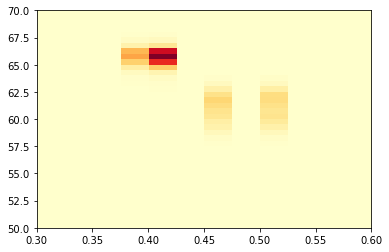

In [23]:
pl.hist2d(elev_mean, rca, range=[[0.3, 0.6], [50, 70]], bins=(12, 40), cmap='YlOrRd')
pl.show()

In [26]:
ratio_mean = []
ratio_std = []
elev = []
nb_files = []

for el in np.unique(elev_mean):
    if el > 1:
        continue
        
    elev.append(el)
    pos = elev_mean == el
    rca_ratio = np.nanmean(rca[pos] )
    
    nb_files.append(np.sum(pos))
    ratio_mean.append(rca_ratio)        

In [28]:
rca_ratio

59.17187154003821

In [32]:
elev = np.array(elev)
ratio_mean = np.array(ratio_mean)
ratio_std = np.array(ratio_std)
nb_files = np.array(nb_files)

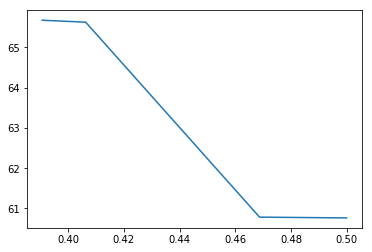

In [33]:
pl.plot(elev[nb_files > 10], ratio_mean[nb_files > 10],)


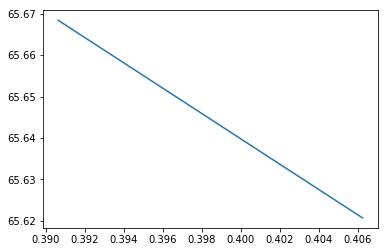

In [34]:
pl.plot(elev[nb_files > 10][0:2], ratio_mean[nb_files > 10][0:2])

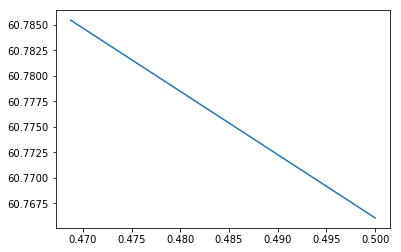

In [36]:
pl.plot(elev[nb_files > 10][-2:], ratio_mean[nb_files > 10][-2:])

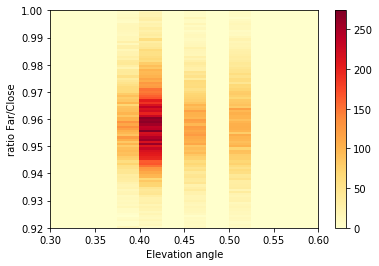

In [108]:
pl.hist2d(elev_mean, far_clutter / close_clutter, range=[[0.3, 0.6], [0.92, 1.00]], bins=(12, 100), cmap='YlOrRd')
pl.colorbar()
pl.xlabel('Elevation angle')
pl.ylabel('ratio Far/Close')
pl.show()

In [94]:
ratio_mean = []
ratio_std = []
elev = []
nb_files = []

for el in np.unique(elev_mean):
    if el > 1:
        continue
        
    elev.append(el)
    pos = elev_mean == el
    rca_ratio = far_clutter[pos] / close_clutter[pos]
    
    nb_files.append(np.sum(pos))
    ratio_mean.append(np.nanmean(rca_ratio))
    ratio_std.append(np.nanstd(rca_ratio))
    
    print(el, np.nanmean(rca_ratio), np.nanstd(rca_ratio))

0.390625 0.9604847510015047 0.020574824992199366
0.40625 0.9601759915919743 0.0197442136989296
0.4375 0.9562907805968989 0.021847785209770553
0.46875 0.9581683979340178 0.024484115345210142
0.5 0.9582556947334699 0.025844518085958494
0.515625 0.9362571926653068 0.0


In [99]:
elev = np.array(elev)
ratio_mean = np.array(ratio_mean)
ratio_std = np.array(ratio_std)
nb_files = np.array(nb_files)

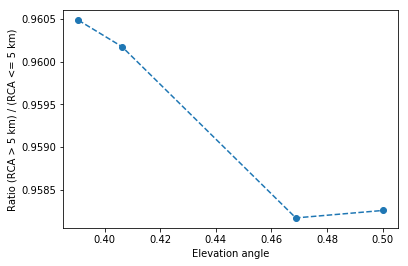

In [106]:
pl.plot(elev[nb_files > 10], ratio_mean[nb_files > 10], 'o--')
pl.xlabel('Elevation angle')
pl.ylabel('Ratio (RCA > 5 km) / (RCA <= 5 km)')
pl.show()

In [107]:
nb_files[nb_files > 10]

array([ 5035, 11895,  5525,  5585])

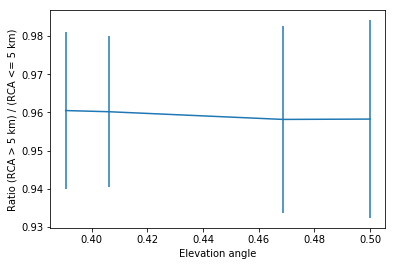

In [113]:
pl.errorbar(elev[nb_files > 10], ratio_mean[nb_files > 10], ratio_std[nb_files > 10])
pl.xlabel('Elevation angle')
pl.ylabel('Ratio (RCA > 5 km) / (RCA <= 5 km)')
pl.show()